# Hello Quantum! 

This is an example notebook that you can use to quickly and easily run a quantum circuit on quantum hardware.

# Initial Config

This will perform basic imports, and ensure that your environment is configured for use with your IBM account. If you have trouble with anything here, please [create an issue](https://github.com/brainwavecollective/hello-quantum/issues/new).

In [56]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService, EstimatorOptions

from IPython.display import display, clear_output
from ipywidgets import Password, Button, VBox, Output, Layout

import numpy as np
import matplotlib.pyplot as plt

# Create the service object
service = None

# Function to prompt for API key input
def prompt_for_api_key():
    # Create widgets
    password_widget = Password(description="API Key:", layout=Layout(width='100%'))
    submit_button = Button(description="Submit")
    reset_button = Button(description="Reset")
    output = Output()

    # Function to handle submit button click
    def on_submit(b):
        with output:
            clear_output(wait=True)
            if password_widget.value:
                try:
                    # Save the account with the provided API key
                    QiskitRuntimeService.save_account(token=password_widget.value, channel="ibm_quantum", overwrite=True)
                    print("API key received and account saved successfully. Attempting to load service again...")
                    try:
                        service = QiskitRuntimeService()
                        print("IBM Quantum service loaded successfully.")
                    except Exception as load_error:
                        print("Failed to load service after saving the API key:", load_error)
                        raise load_error
                except Exception as e:
                    print("Error saving the account:", e)
            else:
                print("No input provided.")

    # Function to handle reset button click
    def on_reset(b):
        with output:
            clear_output(wait=True)
            print("Input reset. Please enter the API key again.")
            password_widget.value = ""  # Clear the input field

    # Attach button events
    submit_button.on_click(on_submit)
    reset_button.on_click(on_reset)

    # Display the widgets
    display(VBox([password_widget, submit_button, reset_button, output]))

# Initial attempt to load QiskitRuntimeService
try:
    service = QiskitRuntimeService()
    print("IBM Quantum service loaded successfully. You may now proceed.")
except Exception as initial_error:
    print("Initial load failed:", initial_error)
    print("Requesting API key input...")
    prompt_for_api_key()


IBM Quantum service loaded successfully. You may now proceed.


# Create and run a simple quantum program

The four steps to writing a quantum program using Qiskit patterns are:

1.  Map the problem to a quantum-native format.

2.  Optimize the circuits and operators.

3.  Execute using a quantum primitive function.

4.  Analyze the results.

### Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) object, then add instructions to it in sequence.

The following code cell creates a circuit that produces a *Bell state,* which is a state wherein two qubits are fully entangled with each other.

<Admonition type="note" title="Note: bit ordering">
  The Qiskit SDK uses the LSb 0 bit numbering where the $n^{th}$ digit has value $1 \ll n$ or $2^n$. For more details, see [Bit-ordering in the Qiskit SDK](https://docs.quantum.ibm.com/guides/bit-ordering).
</Admonition>

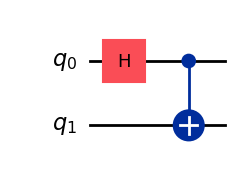

In [57]:
#Bell State Circuit Diagram

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# NOTE: Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

See [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) in the documentation for all available operations.

When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with [Qiskit primitives](./get-started-with-primitives) (explained in detail in [Step 3](#step-3-execute-using-the-quantum-primitives)).

This example measures expectation values by using the `qiskit.quantum_info` submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: `IZ`, `IX`, `ZI`, `XI`, `ZZ`, and `XX`.


In [16]:
# Set up six different observables.

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

<Admonition type="note" title="Operator Notation">
  Here, something like the `ZZ` operator is a shorthand for the tensor product $Z\otimes Z$, which means measuring Z on qubit 1 and Z on qubit 0 together, and obtaining information about the correlation between qubit 1 and qubit 0. Expectation values like this are also typically written as $\langle Z_1 Z_0 \rangle$.

  If the state is entangled, then the measurement of $\langle Z_1 Z_0 \rangle$ should be 1.
</Admonition>



<span id="optimize" />

### Step 2. Optimize the circuits and operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](./transpile#instruction-set-architecture) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA.



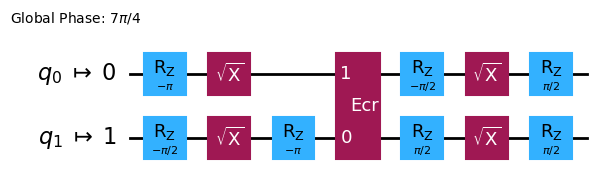

In [37]:
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
#service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

### Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the `Estimator` class. `Estimator` is one of two [primitives](./get-started-with-primitives); the other is `Sampler`, which can be used to get data from a quantum computer.  These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using a [primitive unified bloc (PUB).](primitives#sampler)



In [29]:
# Construct the Estimator instance.

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data
job_id = job.job_id()
print(f">>> Job ID: {job_id}")

>>> Job ID: cwnye782ac5g008hk10g


After a job is submitted, you can wait until either the job is completed within your current python instance, or use the `job_id` to retrieve the data at a later time.  (See the [section on retrieving jobs](./monitor-job#retrieve-job-results-at-a-later-time) for details.)



After the job completes, examine its output through the job's `result()` attribute.

In [58]:
# Get some info about the job 
# NOTE: you can override the Job ID and reuse this for any job in your account 

#Set Default - will retrieve job from previous cell
override_job_id = None  # Replace this with a value if needed, or leave as None
#override_job_id = 'cwnymxv2ac5gde8hk28g'  

# Go get it 
this_job_id = override_job_id if override_job_id else job_id
this_job = service.job(this_job_id)	

# Collect information
status = this_job.status()
backend = this_job.backend()
creation_date = this_job.creation_date  # Access as an attribute
tags = this_job.tags
usage_estimation = this_job.usage_estimation
session_id = this_job.session_id
primitive_id = this_job.primitive_id
inputs = this_job.inputs
image = this_job.image

# Print the collected information
print(f"Job ID: {this_job_id}")
print(f" Job Status: {status}")
print(f" Backend: {backend}")
print(f" Creation Date: {creation_date}")
print(f" Tags: {tags}")
print(f" Usage Estimation: {usage_estimation}")
print(f" Session ID: {session_id}")
print(f" Primitive ID: {primitive_id}")
print(f" Job Inputs: {inputs}")
print(f" Runtime Image: {image}")


###########################
# Conditionally print additional information, if job is completed
if status == 'DONE':
    result = this_job.result()
    logs = this_job.logs()
    error_message = this_job.error_message()

    print(f" Job Result: {result}")
    print(f" Logs: {logs}")

    if error_message:
        print(f" Error Message: {error_message}")
    else:
        print(" No error message; job completed successfully.")
else:
    print("Job is not completed. Results, logs, and error messages are unavailable.")


Job ID: cwnymxv2ac5g008hk28g
 Job Status: DONE
 Backend: <IBMBackend('ibm_sherbrooke')>
 Creation Date: 2024-11-06 15:15:19.482000-07:00
 Tags: None
 Usage Estimation: {'quantum_seconds': 10.573606513577522}
 Session ID: None
 Primitive ID: estimator
 Job Inputs: {'pubs': [[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000020093600310>, [{'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 1}, {'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 1}, {'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 1}, {'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 1}, {'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [51]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

### A note about local workloads

<Admonition type="note" title="Alternative: run the example using a simulator">
  When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the [`fake_provider`](../api/qiskit-ibm-runtime/fake_provider) with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device.

  ```python

  # Use the following code instead if you want to run on a simulator:

  from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
  backend = FakeAlmadenV2()
  estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

  pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
  isa_circuit = pm.run(qc)
  mapped_observables = [
      observable.apply_layout(isa_circuit.layout) for observable in observables
  ]

  job = estimator.run([(isa_circuit, mapped_observables)])
  result = job.result()

  # This is the result of the entire submission.  You submitted one Pub,
  # so this contains one inner result (and some metadata of its own).

  job_result = job.result()

  # This is the result from our single pub, which had five observables,
  # so contains information on all five.

  pub_result = job.result()[0]
  ```
</Admonition>



### Step 4. Analyze the results

The analyze step is typically where you might postprocess your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem.  For this example, plot each of the expectation values that were measured for our circuit.

The expectation values and standard deviations for the observables you specified to Estimator are accessed through the job result's `PubResult.data.evs` and `PubResult.data.stds` attributes. To obtain the results from Sampler, use the `PubResult.data.meas.get_counts()` function, which will return a `dict` of measurements in the form of bitstrings as keys and counts as their corresponding values. For more information, see [Get started with Sampler.](./get-started-with-primitives#get-started-with-sampler)



ValueError: x and y must have same first dimension, but have shapes (6,) and (99,)

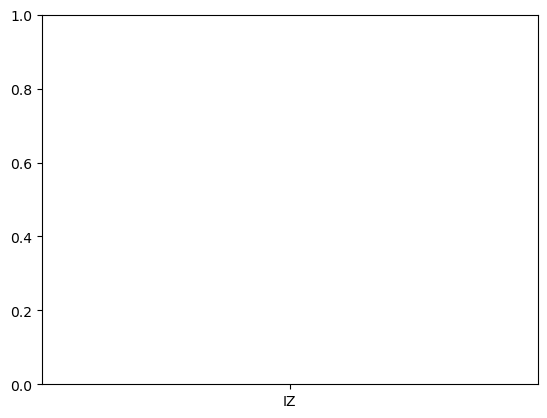

In [59]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (`XX` and `ZZ`) are 1. This is a hallmark of quantum entanglement.



>>> Extracted Numerical Data:
Expected Values (evs): [ 8.04916318e-01  4.61453744e-01  2.47323340e-01  1.99271592e-01
  1.52376033e-01  1.30573248e-01  7.48987854e-02  8.80281690e-03
  7.32899023e-03  2.41657077e-02  3.10344828e-02 -2.44988864e-02
  8.17160368e-03  6.80628272e-03  0.00000000e+00 -7.07290533e-03
  1.80226571e-02 -2.62557078e-02  2.38341969e-02 -4.80668757e-02
 -3.14109166e-02 -1.08108108e-02 -1.24223602e-02  1.02880658e-03
 -8.70511425e-03 -1.55555556e-02 -1.95627158e-02 -1.46726862e-02
 -3.47071584e-02 -1.54394299e-02 -4.35280641e-02 -9.62861073e-03
 -1.39935414e-02  1.23076923e-02  1.30010834e-02  3.17460317e-03
  1.21396055e-02 -2.39463602e-02 -3.23218997e-02  1.90409027e-02
 -5.77367206e-03  1.59722222e-02 -1.29032258e-02 -1.30890052e-02
  9.56429330e-03 -4.31034483e-03  5.81395349e-03  1.23583934e-02
 -3.63447560e-03  1.95227766e-02 -3.10880829e-03  1.94532072e-02
  7.21649485e-03  1.32696391e-02 -5.28541226e-04 -4.70035253e-03
  8.74485597e-03 -2.89473684e-02  5.1

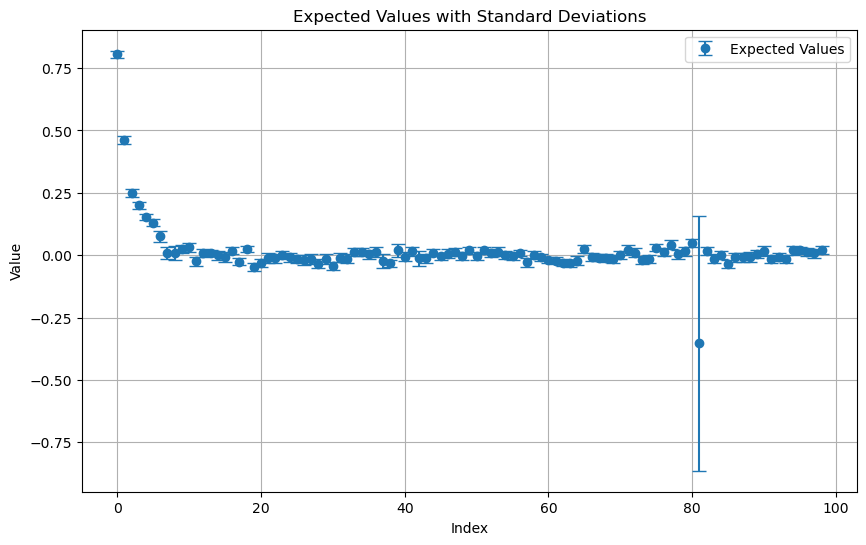

In [53]:
#Bonus: run this cell to explore more of the job information

# Extract and print numerical data
data_bin = pub_result.data
evs = data_bin.evs  # Expected values
stds = data_bin.stds  # Standard deviations
ensemble_standard_error = data_bin.ensemble_standard_error  # Ensemble standard error

# Print extracted data
print(">>> Extracted Numerical Data:")
print("Expected Values (evs):", evs)
print("Standard Deviations (stds):", stds)
print("Ensemble Standard Error:", ensemble_standard_error)

# Analyze and print job metadata
metadata = result[0].metadata
print("\n>>> Job Metadata:")
print(metadata)

# Check specific metadata points
print("\n>>> Analysis of Specific Metadata:")

# Check if 'resilience' key exists and contains 'measure_mitigation'
if 'resilience' in metadata and 'measure_mitigation' in metadata['resilience']:
    if metadata['resilience']['measure_mitigation']:
        print("Measurement mitigation was enabled.")
    else:
        print("Measurement mitigation was not enabled.")
else:
    print("Measurement mitigation information is not available in the metadata.")

# Print the version, using a default if not present
print("Version of the result:", metadata.get('version', 'Unknown'))


# Compute and print aggregate statistics
mean_evs = np.mean(evs)
print("\n>>> Aggregate Statistics:")
print("Mean of Expected Values:", mean_evs)

# Visualize data with a plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(evs)), evs, yerr=stds, fmt='o', capsize=5, label='Expected Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Expected Values with Standard Deviations')
plt.grid(True)
plt.legend()
plt.show()


## Scale to large numbers of qubits

In quantum computing, utility-scale work is crucial for making progress in the field. Such work requires computations to be done on a much larger scale; working with circuits that might use over 100 qubits and over 1000 gates. This example demonstrates how you can accomplish utility-scale work on IBM® QPUs by creating and analyzing a 100-qubit GHZ state.  It uses the Qiskit patterns workflow and ends by measuring the expectation value $\langle Z_0 Z_i \rangle $ for each qubit.

### Step 1. Map the problem

Write a function that returns a `QuantumCircuit` that prepares an $n$-qubit GHZ state (essentially an extended Bell state), then use that function to prepare a 100-qubit GHZ state and collect the observables to be measured.



In [40]:
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.

    Args:
        n (int): Number of qubits in the n-qubit GHZ state

    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc

# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

Next, map to the operators of interest. This example uses the `ZZ` operators between qubits to examine the behavior as they get farther apart.  Increasingly inaccurate (corrupted) expectation values between distant qubits would reveal the level of noise present.



In [41]:
# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 2. Optimize the problem for execution on quantum hardware

Transform the circuit and observables to match the backend's ISA.



In [43]:
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

### Step 3. Execute on hardware

Submit the job and enable error suppression by using a technique to reduce errors called [dynamical decoupling.](../api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions) The resilience level specifies how much resilience to build against errors. Higher levels generate more accurate results, at the expense of longer processing times.  For further explanation of the options set in the following code, see [Configure error mitigation for Qiskit Runtime.](./configure-error-mitigation)



In [45]:
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Create an Estimator object
estimator = Estimator(backend, options=options)

In [46]:
# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

cwnymxv2ac5g008hk28g


### Step 4. Post-process results

After the job completes, plot the results and notice that $\langle Z_0 Z_i \rangle$ decreases with increasing $i$, even though in an ideal simulation all $\langle Z_0 Z_i \rangle$ should be 1.



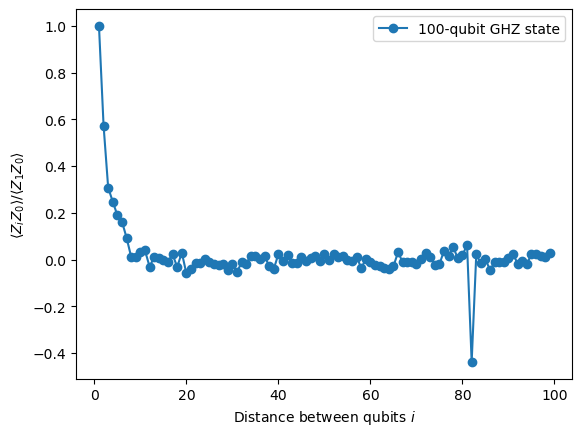

In [54]:
# data
data = list(range(1, len(operators)+1)) # Distance between the Z operators
result = job.result()[0]
values = result.data.evs # Expectation value at each Z operator.
values = [v / values[0] for v in values] # Normalize the expectation values to evaluate how they decay with distance.

# plotting graph
plt.plot(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $')
plt.legend()
plt.show()

The previous plot shows that as the distance between qubits increases, the signal decays because of the presence of noise.



## Next steps
  *   Learn how to [build quantum circuits](https://docs.quantum.ibm.com/guides/map-problem-to-circuits) in more detail.
  *   Try a [tutorial](https://learning.quantum.ibm.com/catalog/tutorials) in IBM Quantum Learning.
  *   [Contact Daniel at the Brain Wave Collective](mailto:daniel@brainwavecollective.ai) with any questions.